In [173]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

%matplotlib inline

### Proof of Concept

In [174]:
#Using an open source Reddit API project called pushshift.io which allows one to loop over timeframes
#to get more than just the 1000 most recent comments available, and also returns a list of dictionaries,
#allowing easier conversion into pandas.  The dictionary keys for each comment are similar to the main Reddit API.

#The url below calls for the most recent 1000 comments from threads on r/AskMen.
url = "https://api.pushshift.io/reddit/search/comment/?subreddit=askmen&sort=des&size=1000"

In [175]:
headers = {'User-agent': 'eamonious'}
res = requests.get(url, headers=headers)
res.status_code

200

In [176]:
json = res.json()
comments = pd.DataFrame(json['data'])

In [177]:
comments.columns

Index(['author', 'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'author_fullname',
       'author_patreon_flair', 'body', 'created_utc', 'distinguished',
       'gildings', 'id', 'link_id', 'no_follow', 'parent_id', 'permalink',
       'retrieved_on', 'score', 'send_replies', 'stickied', 'subreddit',
       'subreddit_id'],
      dtype='object')

Features we are interested in: 
- body: raw text of the comment
- created_utc: timestamp of the comment
- id: comment unique id
- link_id: contains slug for the parent thread. could be useful.
- parent_id: unique id of parent comment (or thread id for 1st tier comments). I can use to identify first tier comments.
- score: comment upvote total
- subreddit: subreddit comment was in.  this will be the target.

In [178]:
#Removes all unnecessary features
comments = comments[['body','created_utc','id','link_id','parent_id','score','subreddit']]

For my project, I have chosen the subreddits r/AskMen and r/AskWomen.  The way these subreddits work is people make threads in which they ask a question looking for answers from only male or only female redditors, respectively.  So we can expect the first tier comments in each thread to be from men or women, respectively.  What I am interested in is trying to classify these first tier comments as (Man answering question in AskMen) vs. (Woman answering question in AskWomen).  Accordingly, we only want to look at first-tier comments, i.e.; direct replies to thread.  Later responses may be from either gender.  We can filter for this using the 'parent_id' feature.  First tier comments all begin with 't3_' followed by a thread id, as opposed to a comment id.

In [179]:
#Drops all comments that are not in the first tier, i.e.; direct responses to the original post.
comments['parent_id'] = comments['parent_id'].map(lambda x: x if 't3_' in x else 0)
comments = comments[comments['parent_id']!=0]

In [180]:
len(comments)

358

Based on experimentation, it looks like the percentage of every 1000 comments that are first tier comments is approximately the same in AskMen and AskWomen, so the classes should remain roughly balanced.

In [181]:
comments.head()

,body,created_utc,id,link_id,parent_id,score,subreddit
1,I love all the marvel movies and am not very p...,1545250190,ec4tzcw,t3_a7od5g,t3_a7od5g,1,AskMen
2,Post a pic. I wanna see if you are telling the...,1545250177,ec4tys2,t3_a7p3gr,t3_a7p3gr,1,AskMen
5,The leader’s head on a platter.,1545250135,ec4twqs,t3_a7pwyi,t3_a7pwyi,1,AskMen
9,"No, I'm an atheist, and my view is that religi...",1545250126,ec4tw9c,t3_a7pwyi,t3_a7pwyi,1,AskMen
11,[removed],1545250103,ec4tv4e,t3_a7ptmf,t3_a7ptmf,1,AskMen


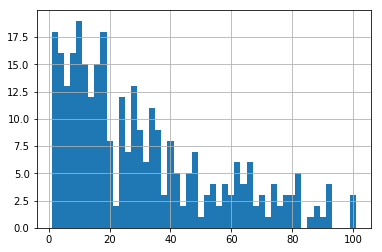

In [182]:
#Shows a distribution of the word length of comments (greater than 99 excluded)
comments['body'].map(lambda x: len(x.split(' '))).hist(range=(1,101),bins=50);

It may be desirable to remove comments with, say, 4 words or fewer, as these may not be very meaningful to classify.  But I'm not certain.  Some one or two word comments could actually classify well.

### Construction of For Loop

Reddit limits you to grabbing 1000 comments at a time, and this extends to the pushshift.io API as well.  To collect more than 1000 comments, and also to reflect a wider variety of timeframes than simply the last few days, I will use a feature in the pushshift.io API that allows you to query based on a before and after timestamp.  

I am going to use the before feature and collect the 1000 most recent comments in the subreddit at 12 day intervals.  I chose 12 days because it will quickly give me a variety of times of month, days of week, etc., and it is a large enough gap that all comments will certainly be new and I will be able to cover a full year's worth of time at least to catch all seasons.  

The API uses the epoch timestamp, a numerical representation.  12 days corresponds to 1036800.  What I will do is use an initial timestamp from this week and then subtract 1036800 from it in each request, collecting comments further and further back in time and appending them until I have collected 30000 comments from the AskMen subreddit.  I will then do the same thing for AskWomen.

AskMen Data Grab:

In [183]:
url = "https://api.pushshift.io/reddit/search/comment/?subreddit=askmen&before=1545243580&sort=des&size=1000"
headers = {'User-agent': 'eamonious'}
res = requests.get(url, headers=headers)
json = res.json()
comments = pd.DataFrame(json['data'])
comments = comments[['body','created_utc','id','link_id','parent_id','score','subreddit']]
comments['parent_id'] = comments['parent_id'].map(lambda x: x if 't3_' in x else 0)
comments = comments[comments['parent_id']!=0]
comments = comments[comments['body']!='[removed]']

In [187]:
for i in range(1,80):
    url = "https://api.pushshift.io/reddit/search/comment/?subreddit=askmen&before={}&sort=des&size=1000".format(1545243580 - i*1036800)
    headers = {'User-agent': 'eamonious'}
    res = requests.get(url, headers=headers)
    json = res.json()
    commentbloc = pd.DataFrame(json['data'])
    commentbloc = commentbloc[['body','created_utc','id','link_id','parent_id','score','subreddit']]
    commentbloc['parent_id'] = commentbloc['parent_id'].map(lambda x: x if 't3_' in x else 0)
    commentbloc = commentbloc[commentbloc['parent_id']!=0]
    commentbloc = commentbloc[commentbloc['body']!='[removed]']
    comments = pd.concat([comments, commentbloc], ignore_index=True)


In [188]:
len(comments)

43774

AskWomen Data Grab:

In [221]:
url = "https://api.pushshift.io/reddit/search/comment/?subreddit=askwomen&before=1545243580&sort=des&size=1000"
headers = {'User-agent': 'eamonious'}
res = requests.get(url, headers=headers)
json = res.json()
commentsw = pd.DataFrame(json['data'])
commentsw = commentsw[['body','created_utc','id','link_id','parent_id','score','subreddit']]
commentsw['parent_id'] = commentsw['parent_id'].map(lambda x: x if 't3_' in x else 0)
commentsw = commentsw[commentsw['parent_id']!=0]
commentsw = commentsw[commentsw['body']!='[removed]']

In [222]:
for i in range(1,80):
    url = "https://api.pushshift.io/reddit/search/comment/?subreddit=askwomen&before={}&sort=des&size=1000".format(1545243580 - i*1036800)
    headers = {'User-agent': 'eamonious'}
    res = requests.get(url, headers=headers)
    json = res.json()
    commentbloc = pd.DataFrame(json['data'])
    commentbloc = commentbloc[['body','created_utc','id','link_id','parent_id','score','subreddit']]
    commentbloc['parent_id'] = commentbloc['parent_id'].map(lambda x: x if 't3_' in x else 0)
    commentbloc = commentbloc[commentbloc['parent_id']!=0]
    commentbloc = commentbloc[commentbloc['body']!='[removed]']
    commentsw = pd.concat([commentsw, commentbloc], ignore_index=True)

In [223]:
len(commentsw)

41555

In [192]:
comments.to_csv('askmen.csv')

In [224]:
commentsw.to_csv('askwomen.csv')

### Cleaning Away Mod Messages and Deleted Comments

In [283]:
comments = pd.read_csv('askmen.csv')

In [258]:
commentsw = pd.read_csv('askwomen.csv')

AskWomen Cleaning

In [259]:
commentsw.dropna(inplace=True)

In [260]:
commentsw['body'].value_counts()[0:45]

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Below, I remove mod comment removals by filtering for certain typifying language.  I also remove deleted comments.

In [261]:
commentsw['body'] = commentsw['body'].map(lambda x: 0 if 'has been removed' in x else x)

In [262]:
commentsw = commentsw[commentsw['body']!='[deleted]']

In [263]:
commentsw['body'] = commentsw['body'].map(lambda x: 0 if 'emoved' in str(x)[0:10] else x)

In [264]:
commentsw['body'] = commentsw['body'].map(lambda x: 0 if 'AskWomen' in str(x) else x)

In [265]:
commentsw = commentsw[commentsw['body']!=0]

In [266]:
commentsw.to_csv('askwomen_cleaned')

AskMen Cleaning

In [284]:
comments['body'].value_counts()[0:45]

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [285]:
comments.dropna(inplace=True)

In [286]:
comments['body'] = comments['body'].map(lambda x: 0 if 'has been removed' in x else x)

In [287]:
comments = comments[comments['body']!=0]

In [289]:
comments['body'] = comments['body'].map(lambda x: 0 if 'AskMen' in x else x)

In [290]:
comments = comments[comments['body']!=0]

In [292]:
comments = comments[comments['body']!='[deleted]']

In [293]:
comments['body'].value_counts()[0:45]

Yes                                                                                                                                                                                                                                                                                                                                                                                                                             8
Never.                                                                                                                                                                                                                                                                                                                                                                                                                          7
Nope.                                                                                                                                                               

In [307]:
comments.to_csv('askmen_cleaned')

### Final Cleaning

In [308]:
commentsm = pd.read_csv('askmen_cleaned')
commentsw = pd.read_csv('askwomen_cleaned')

One thing I want to do is remove any duplicates in the id column, as this represents the same comment being gathered more than once.

In [310]:
len(commentsm.drop_duplicates('id'))

33395

In [311]:
len(commentsw.drop_duplicates('id'))

38410

In [312]:
commentsm.drop_duplicates('id',inplace=True)

In [313]:
commentsw.drop_duplicates('id',inplace=True)

In [318]:
commentsm = commentsm[commentsm['body']!='\\[removed\]']

In [320]:
commentsw = commentsw[commentsw['body']!='Please feel free to respond based on the genders that you find attractive. This question is not limited to women who date men.']

In [321]:
commentsm.to_csv('askmen_cleaned')

In [322]:
commentsw.to_csv('askwomen_cleaned')